In [45]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn, SKLearnModel
from sagemaker.serverless import ServerlessInferenceConfig
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import uuid


## Models    
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

## Metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV

## Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

## Sagemaker Session

In [3]:
sagemaker_session = sagemaker.Session(default_bucket='sagemaker-sociedad-ec-estadistica')
region = sagemaker_session.boto_region_name
role = get_execution_role()

In [3]:
# Creación de la carpeta
os.makedirs("data", exist_ok=True)
os.makedirs("prepared", exist_ok=True)

## Data Load

In [36]:
# Descarga de datos
file_names = ['precio_casas.csv', 'uszips.csv', 'uscities.csv']
s3_client = boto3.client("s3")
for file_name in file_names:
    s3_client.download_file("s3datossociedadecuatorianaestadistica", file_name, "./data/"+file_name)

In [4]:
# Lectura de datos
realstate_data = pd.read_csv("data/precio_casas.csv")
realstate_data.head(1)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN


In [5]:
uscities = pd.read_csv("data/uscities.csv")
uscities.head(1)

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18908608,11080.3,shape,False,True,America/New_York,1,11229 11228 11226 11225 11224 11222 11221 1122...,1840034016


In [6]:
uszips = pd.read_csv("data/uszips.csv")
uszips.head(5)

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18027,-66.75266,Adjuntas,PR,Puerto Rico,True,NaN,16834.0,100.9,72001,Adjuntas,"{""72001"": 98.74, ""72141"": 1.26}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36075,-67.17541,Aguada,PR,Puerto Rico,True,NaN,37642.0,479.2,72003,Aguada,"{""72003"": 100}",Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45744,-67.12225,Aguadilla,PR,Puerto Rico,True,NaN,49075.0,551.7,72005,Aguadilla,"{""72005"": 99.76, ""72099"": 0.24}",Aguadilla|Moca,72005|72099,False,False,America/Puerto_Rico
3,606,18.16585,-66.93716,Maricao,PR,Puerto Rico,True,NaN,5590.0,48.7,72093,Maricao,"{""72093"": 82.27, ""72153"": 11.66, ""72121"": 6.06}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29110,-67.12243,Anasco,PR,Puerto Rico,True,NaN,25542.0,265.7,72011,Añasco,"{""72011"": 96.71, ""72099"": 2.82, ""72083"": 0.37,...",Añasco|Moca|Las Marías|Aguada,72011|72099|72083|72003,False,False,America/Puerto_Rico


## Data Cleaning and intial exploration

In [7]:
realstate_data.head(10)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN
5,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN
6,1205.0,for_sale,50000.0,3.0,1.0,0.20,1298094.0,Ciales,Puerto Rico,639.0,2040.0,NaN
7,50739.0,for_sale,71600.0,3.0,2.0,0.08,1048466.0,Ponce,Puerto Rico,731.0,1050.0,NaN
8,81909.0,for_sale,100000.0,2.0,1.0,0.09,734904.0,Ponce,Puerto Rico,730.0,1092.0,NaN
9,65672.0,for_sale,300000.0,5.0,3.0,7.46,1946226.0,Las Marias,Puerto Rico,670.0,5403.0,NaN


In [8]:
realstate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


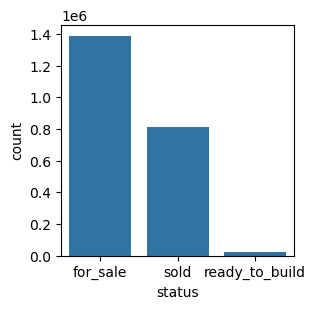

In [9]:
# House Status
plt.figure(figsize = (3, 3))
sns.barplot(realstate_data.status.value_counts())
plt.show()

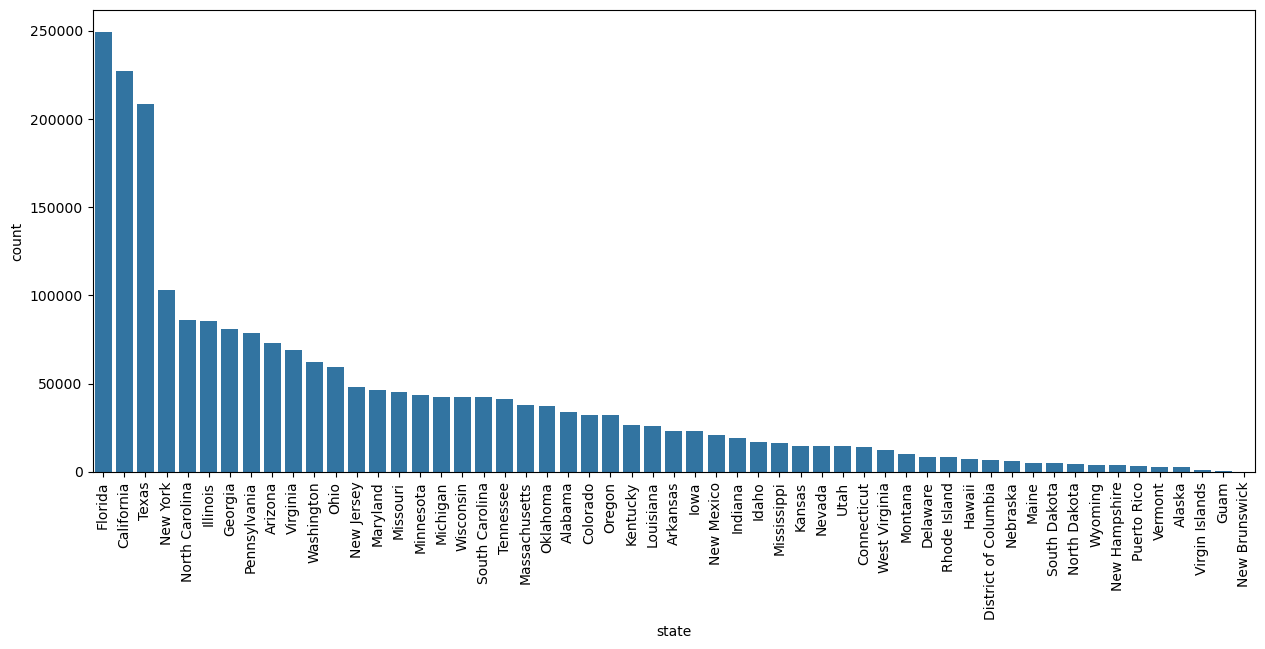

In [10]:
# States plot
plt.figure(figsize = (15, 6))
sns.barplot(realstate_data.state.value_counts())
plt.xticks(rotation = 90)
plt.show()

In [11]:
# States plot
realstate_data.zip_code.value_counts()

zip_code
33993.0    2472
33981.0    2282
33974.0    1996
33160.0    1718
32909.0    1707
           ... 
51441.0       1
50848.0       1
52047.0       1
50668.0       1
99335.0       1
Name: count, Length: 30334, dtype: int64

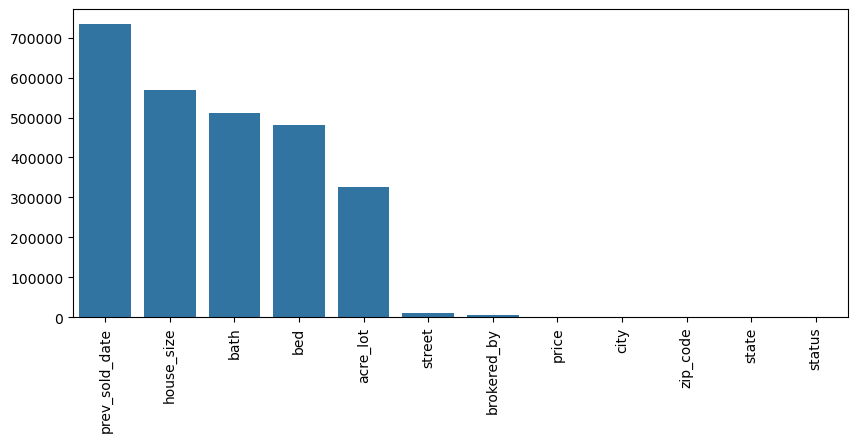

In [12]:
## Null values
plt.figure(figsize=(10, 4))
sns.barplot(realstate_data.isnull().sum().sort_values(ascending=False))
plt.xticks(rotation=90)
plt.show()

In [13]:
uszips[['zip', 'population', 'density']].isnull().sum()

zip            0
population    17
density       17
dtype: int64

In [14]:
uscities[['city', 'population', 'density']].isnull().sum()

city          0
population    0
density       0
dtype: int64

In [8]:
## Clean and preprocess

def clean_realstate_df(df, zips_dict, cities_dict):
    """
    Cleans the real estate dataframe and merges it with zip and city data.

    Parameters:
    df (pd.DataFrame): The real estate data.
    zips_dict (dict): A dictionary containing zip code related data.
    cities_dict (dict): A dictionary containing city related data.

    Returns:
    pd.DataFrame: Cleaned real estate data with additional zip and city information.
    """
    acre_to_m2 = 4046.86
    sqft_to_m2 = 0.092903

    df_cleaned = (df
        .assign(
            prev_sold_date=lambda df_: (
                df_.prev_sold_date.fillna('not_previously_sold')
                .astype("object")),
            m2_lot=lambda df_: ((df_.acre_lot * acre_to_m2)
                                .astype('float')),
            house_size_m2=lambda df_: ((df_.house_size * sqft_to_m2)
                                       .astype('float')),
            bed=lambda df_: df_.bed.apply(lambda x: 9 if x > 8 else x),
            bath=lambda df_: df_.bath.apply(lambda x: 8 if x > 7 else x),
            property_house_ratio=lambda df_: df_.m2_lot / df_.house_size_m2,
            rooms_bathrooms=lambda df_: df_.bed / df_.bath,
            price_sqr_mtrs=lambda df_: df_.price / df_.m2_lot,
            city_state=lambda df_: (df_['city'] + '-' + df_['state']),
            log_price=lambda df_: np.log(df_.price + 1),
            log_h_size_m2=lambda df_: np.log(df_.house_size_m2 + 1)
        )
        .dropna()
        .reset_index(drop=True)
        .loc[:, ['status', 'price', 'log_price', 'bed', 'bath', 'state', 'city_state',
                 'zip_code', 'm2_lot', 'house_size_m2', 'log_h_size_m2',
                 'property_house_ratio', 'rooms_bathrooms',
                 'price_sqr_mtrs']]

    ).query('log_price >= 2.5')

    df_cleaned['zip_population'] = df_cleaned.zip_code.map(zips_dict['zip_population']).fillna(1)
    df_cleaned['zip_density'] = df_cleaned.zip_code.map(zips_dict['zip_density']).fillna(0)

    df_cleaned['city_density'] = df_cleaned.city_state.map(cities_dict['city_density'])
    df_cleaned['city_population'] = df_cleaned.city_state.map(cities_dict['city_population'])
    df_cleaned['city_density'] = df_cleaned['city_density'].fillna(df_cleaned.city_density.median())
    df_cleaned['city_population'] = df_cleaned['city_population'].fillna(df_cleaned.city_population.median())

    return df_cleaned

def clean_uszips(df):
    """
    Cleans the US zip codes dataframe and converts it to a dictionary.

    Parameters:
    df (pd.DataFrame): The US zip codes data.

    Returns:
    dict: A dictionary with zip code data.
    """
    clean = (df
        .loc[:, ['zip', 'population', 'density']]
        .assign(
            population=lambda df_: df_.population.fillna(1).astype('int'),
            density=lambda df_: df_.density.fillna(0).astype('int')
        )
        .rename(columns={
            'zip': 'zip_code',
            'population': 'zip_population',
            'density': 'zip_density'
        }).set_index('zip_code'))
    return clean.to_dict()

def clean_uscities(df):
    """
    Cleans the US cities dataframe and converts it to a dictionary.

    Parameters:
    df (pd.DataFrame): The US cities data.

    Returns:
    dict: A dictionary with city data.
    """
    clean = (df
        .loc[:, ['city', 'state_name', 'population', 'density']]
        .dropna()
        .assign(
            population=lambda df_: df_.population.astype('int'),
            density=lambda df_: df_.density.astype('int'),
            city=lambda df_: df_.city.apply(lambda x: x.replace('-', ' ')),
            city_state=lambda df_: (df_['city'] + '-' + df_['state_name'])
        )
        .loc[:, ['city_state', 'population', 'density']]
        .rename(columns={
            'population': 'city_population',
            'density': 'city_density'
        }).set_index('city_state'))
    return clean.to_dict()


In [10]:
## Map populations of zips and cities and clean data set.
cities = clean_uscities(uscities)
zips = clean_uszips(uszips)
realstate_clean = clean_realstate_df(realstate_data, zips_dict=zips, cities_dict=cities)


In [51]:
# Escritura de datos procesados
file_name_clean = 'realstate.csv'.replace('.csv','-clean.csv')
realstate_clean.to_csv('prepared/'+file_name_clean, index=False)

## Exploratory Data Analysis

In [9]:
realstate_clean = pd.read_csv('./prepared/realstate-clean.csv')
sample = realstate_clean.sample(100000)

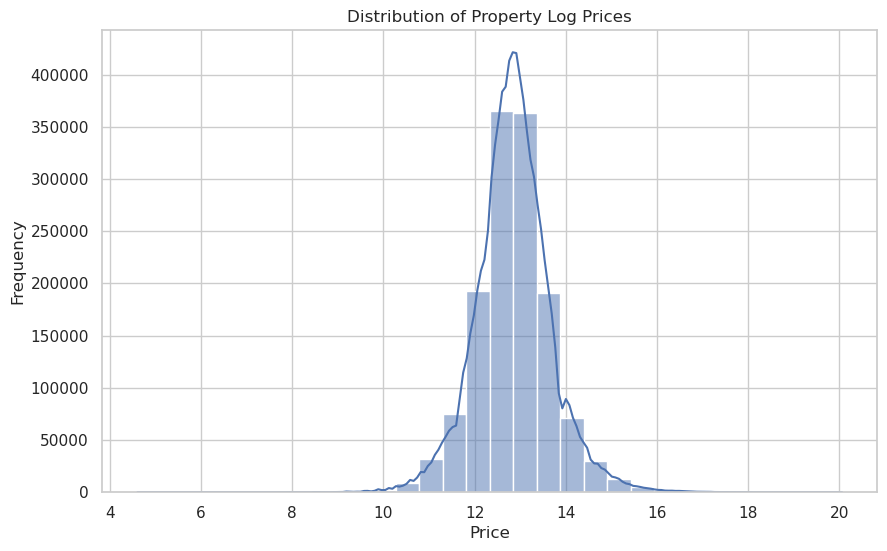

In [10]:
# Set the style of the visualization
sns.set(style="whitegrid")

# 1. Distribution of Prices
plt.figure(figsize=(10, 6))
sns.histplot(np.log(realstate_clean['price']), kde=True, bins=30)
plt.title('Distribution of Property Log Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


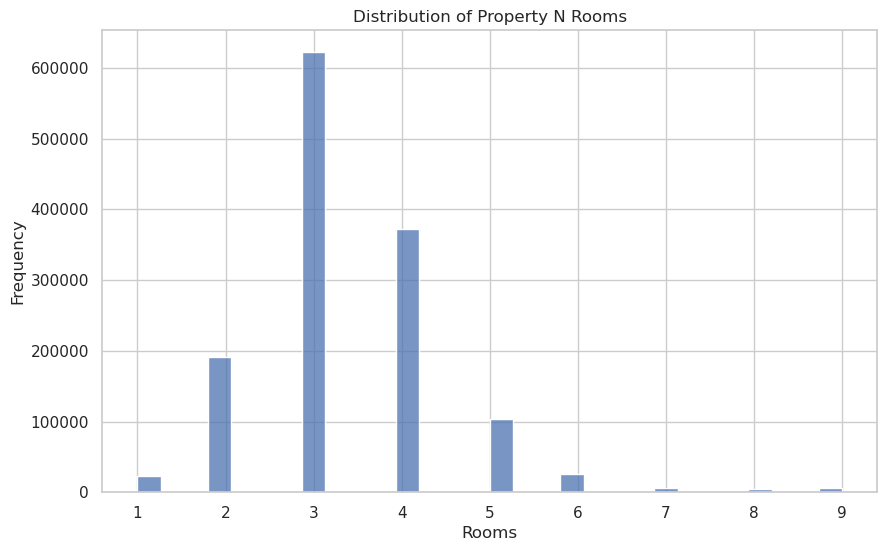

In [11]:
# 1.1 Distribution of Rooms
plt.figure(figsize=(10, 6))
sns.histplot(realstate_clean.bed, kde=False, bins=30)
plt.title('Distribution of Property N Rooms')
plt.xlabel('Rooms')
plt.ylabel('Frequency')
plt.show()

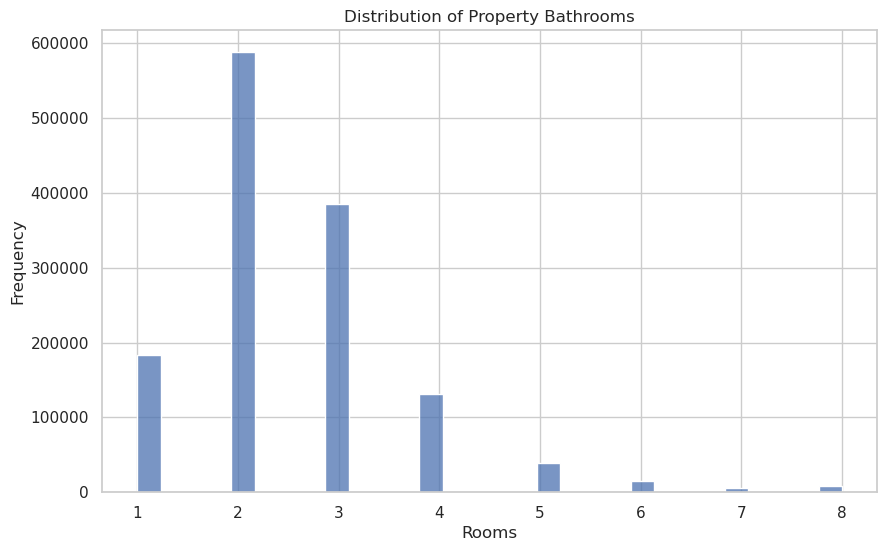

In [12]:
# 1.1 Distribution of Rooms
plt.figure(figsize=(10, 6))
sns.histplot(realstate_clean.bath, kde=False, bins=30)
plt.title('Distribution of Property Bathrooms')
plt.xlabel('Rooms')
plt.ylabel('Frequency')
plt.show()

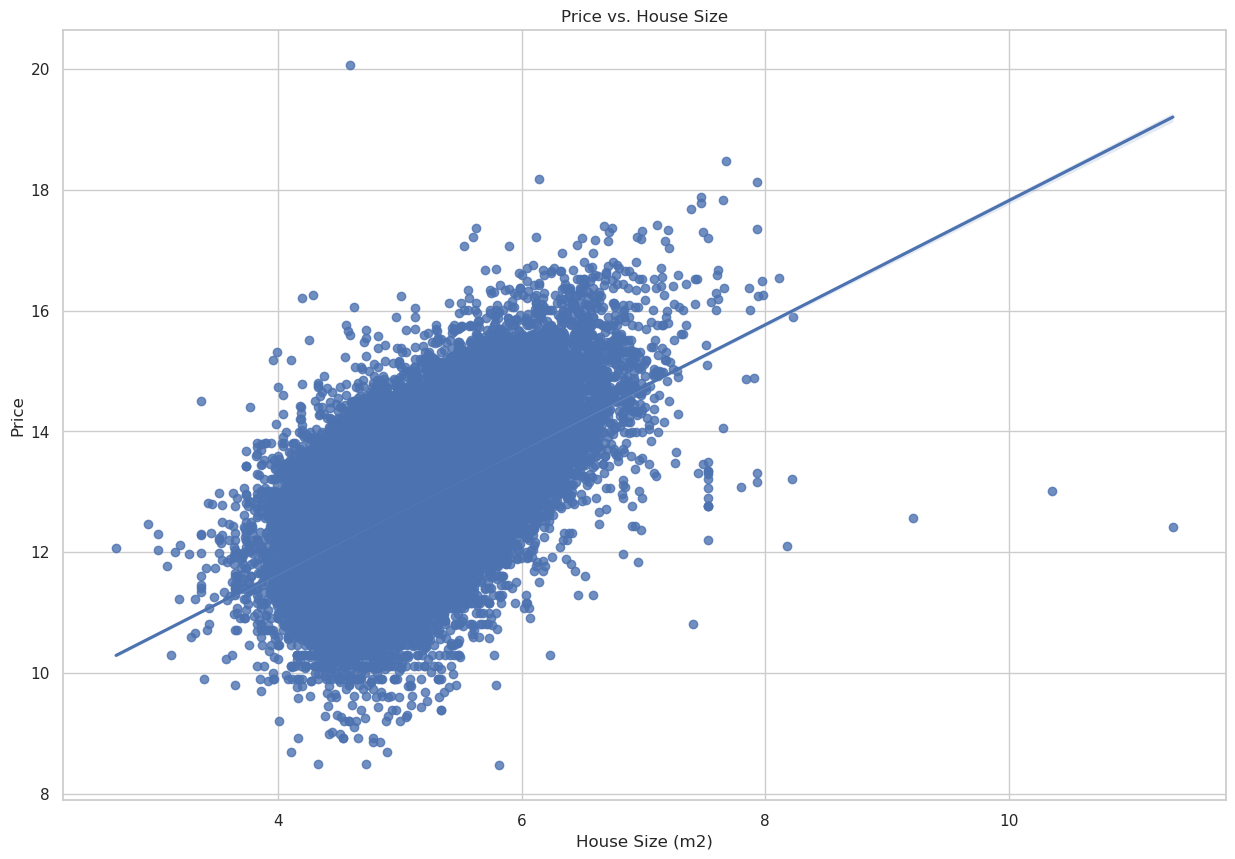

In [13]:
# 2. Relationship between Price and House Size
plt.figure(figsize=(15, 10))
sns.regplot(data=sample, x='log_h_size_m2', y='log_price')
plt.title('Price vs. House Size')
plt.xlabel('House Size (m2)')
plt.ylabel('Price')
#plt.legend(title='State')
plt.show()

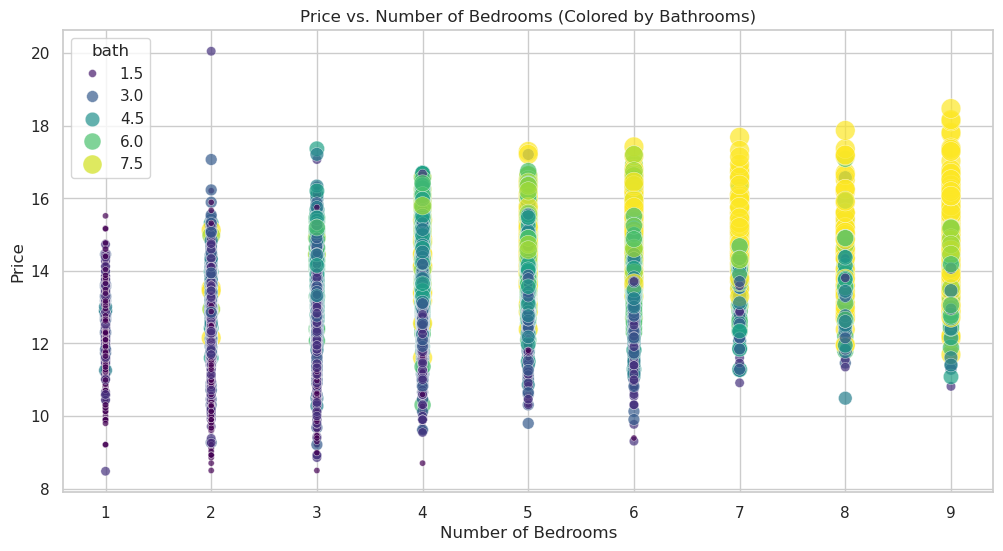

In [14]:
# 3. Price vs. Number of Bedrooms and Bathrooms
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sample, x='bed', y='log_price', hue='bath', palette='viridis', size='bath', sizes=(20, 200), alpha=0.7)
plt.title('Price vs. Number of Bedrooms (Colored by Bathrooms)')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.show()

## Preparing for ML Modelling

In [15]:
y = realstate_clean.loc[:, ['log_price']]
X = realstate_clean.drop(['price', 'city_state', 'zip_code', 'log_price', 'price_sqr_mtrs'], axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
def plot_predicted_vs_actual(y_true, y_pred, model_name="Model"):
    # Create the scatterplot
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_true, y=y_pred, s=50, color="blue", alpha=0.6, edgecolor="w", label='Predictions')
    
    # Plot the 45-degree line (perfect fit line)
    max_val = max(np.max(y_true), np.max(y_pred))
    min_val = min(np.min(y_true), np.min(y_pred))
    
    plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, linestyle='--', label='45-degree line')

    # Add labels and title
    plt.title(f'Predicted vs Actual values for {model_name}', fontsize=14)
    plt.xlabel('Actual values', fontsize=12)
    plt.ylabel('Predicted values', fontsize=12)
    plt.legend(loc='upper left')

    # Show the plot
    plt.grid(True)
    plt.show()

In [24]:
# Select numerical and categorical columns
numeric = list(X.select_dtypes(['float', 'int']).columns)
categorical_state = ['state']
categorical_status = ['status']

# Combined preprocessing for numerical and categorical columns
preprocessing_combined = ColumnTransformer(
    transformers=[
        ('Numeric', StandardScaler(), numeric),  # Scale numeric columns
        ('State', OrdinalEncoder(), categorical_state),  # Ordinal encode 'state'
        ('Status', OneHotEncoder(), categorical_status)  # One-hot encode 'status'
    ],
    remainder='passthrough'  # Leave other columns unchanged
)

Running LinearRegression...


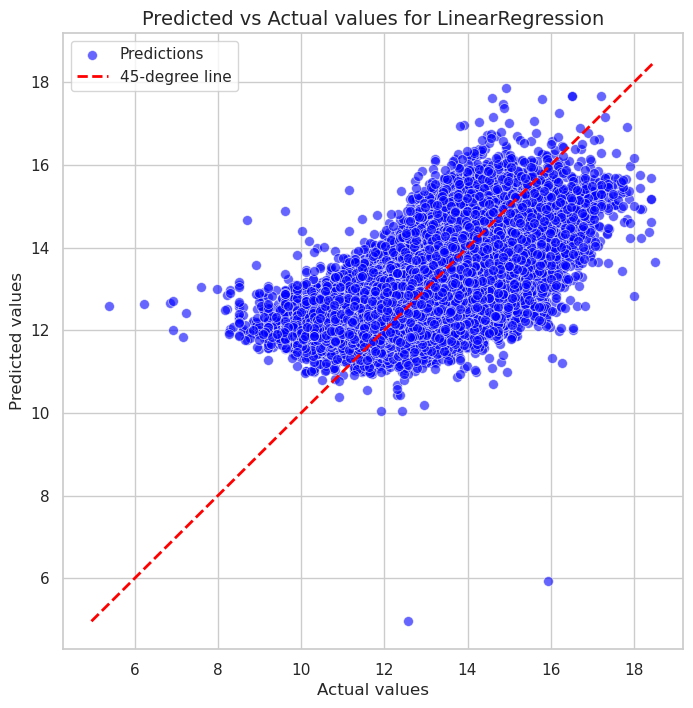

Running Ridge...


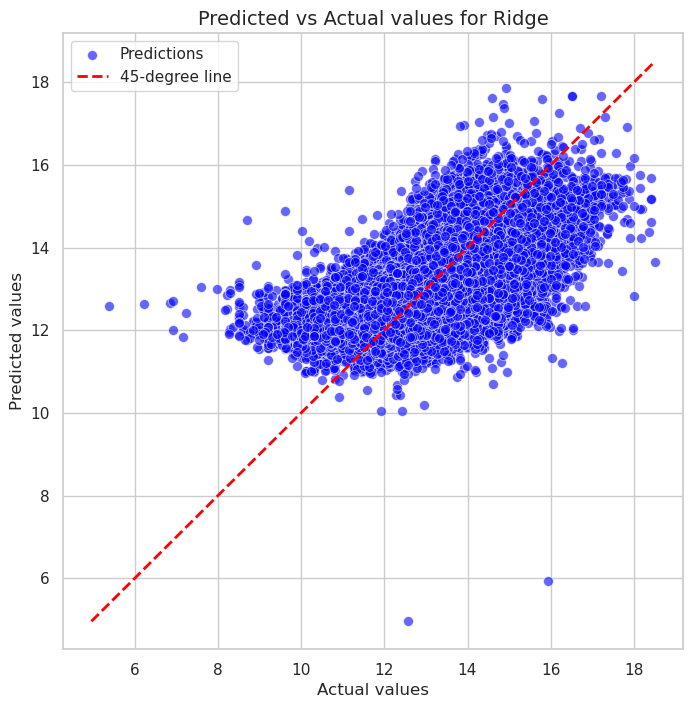

Running Lasso...


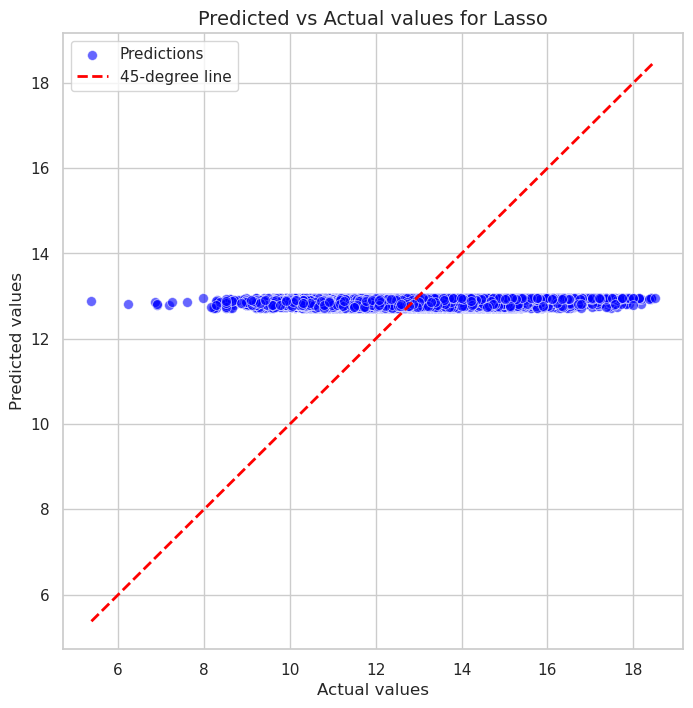

Running RandomForest...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


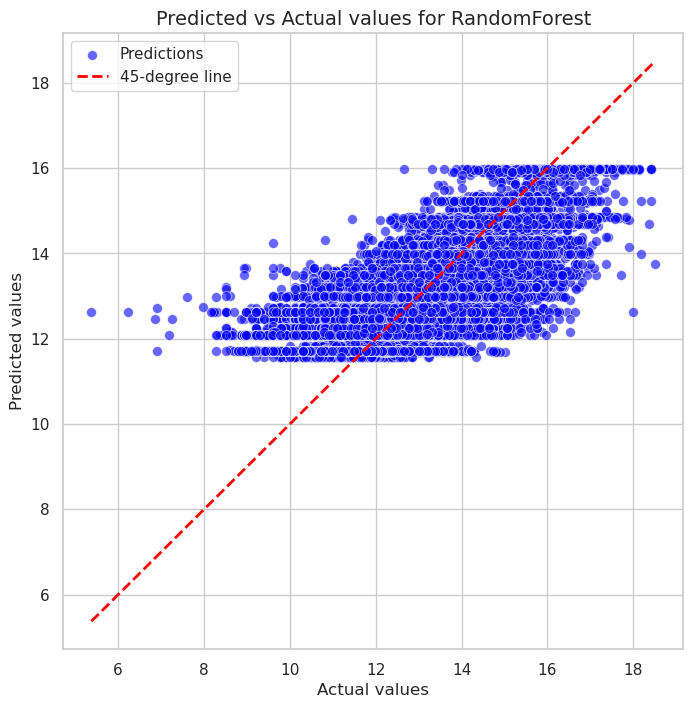

Running GradientBoosting...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


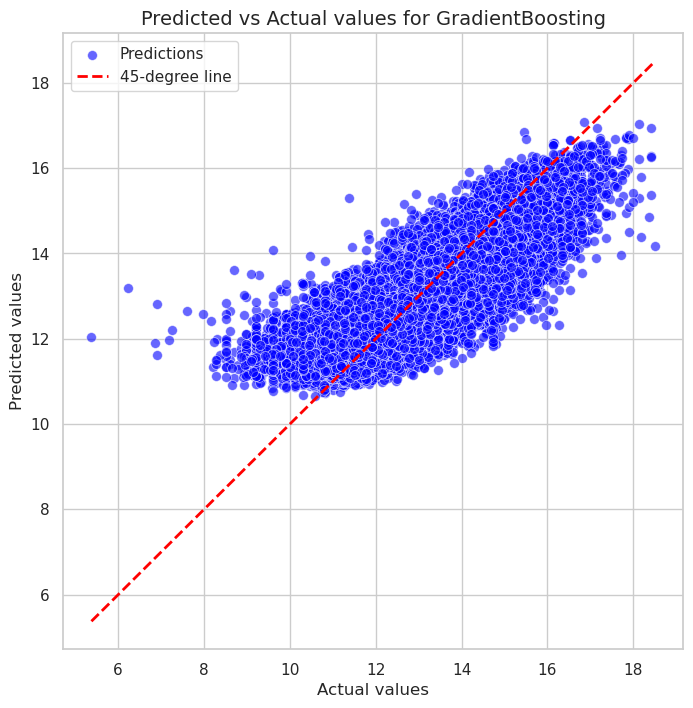

              Model       MSE      RMSE        R2      MAPE       MAE
0  LinearRegression  0.349735  0.591384  0.485141  0.034409  0.438739
1             Ridge  0.349735  0.591384  0.485141  0.034409  0.438739
2             Lasso  0.663802  0.814740  0.022790  0.047503  0.606232
3      RandomForest  0.318934  0.564743  0.530484  0.032715  0.417018
4  GradientBoosting  0.185408  0.430590  0.727053  0.024207  0.307977


In [43]:
# 2. Define Models and Parameter Grids
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(max_depth=5),
    'GradientBoosting': GradientBoostingRegressor(max_depth=5)
}

metrics_data = []

# Assuming X_train, X_test, y_train, y_test are already defined
# 4. Loop through each model and perform RandomizedSearchCV
for name, model in models.items():
    print(f"Running {name}...")

    # Create pipeline (optional, here it includes scaling)
    pipeline = Pipeline([('preprocessing', preprocessing_combined),
                        ('model', model)])

    pipeline.fit(X_train, y_train)

    # 5. Predict on test data
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    plot_predicted_vs_actual(y_test.values.ravel(), y_pred.ravel(), model_name=name)

    # Append metrics to list
    metrics_data.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'MAE': mae
    })
    
# 6. Create a DataFrame to store the results
results_df = pd.DataFrame(metrics_data)

# Display the results
print(results_df)

## Go with Gradient Boosting Regressor

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import numpy as np
import pandas as pd

param_dict = {
    'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'model__n_estimators': [100, 200, 500]
}

model = GradientBoostingRegressor()

pipeline = Pipeline([('preprocessing', preprocessing_combined),
                        ('model', model)])

# Perform GridSearchCV
search = RandomizedSearchCV(pipeline, param_dict, n_iter=5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
search.fit(X_train, y_train)

# Store the best model
best_model = search.best_estimator_

# Predict on test data using the best model
y_pred = best_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Append metrics to list
metrics_data = {
    'Model': 'GradientBoostingRegressor',
    'Best Params': search.best_params_,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'MAPE': mape,
    'MAE': mae
}

# Create a DataFrame to store the results
results_df = pd.DataFrame([metrics_data])  # Wrap the dictionary in a list

# Display the results
print(results_df)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  from scipy.sparse import csr_matrix, issparse
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  from scipy.sparse import csr_matrix, issparse
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed 